Github project URL: https://github.com/KenMcCarthy24/DTSA_5509_Final

# Introduction

The purpose of this project is to train classification algorithm to attempt to predict various types of heart arrhythmias based on ECG Data. 

An ECG (Electrocardiogram) is a medical test that measures the electrical signals of the heart and is essential for diagnosing many heart related diseases. A healthy individual's heartbeat on an ECG is characterized by a distinctive waveform, representing the normal functioning of the heart.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/SinusRhythmLabels.png/605px-SinusRhythmLabels.png" width="300"/>
</div>

Image source: https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/SinusRhythmLabels.png/605px-SinusRhythmLabels.png

However, when the heart is not functioning optimally, the ECG detects distortions to the anticipated waveform, and severe and life-threatening arrhythmias might present a different or nonexistent waveform altogether.

This project attempts to use machine learning techniques to classify ECG data as either healthy or as one of four different kinds of arrhythmia. 

Raw Dataset source:


Moody GB, Mark RG. The impact of the MIT-BIH Arrhythmia Database. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)

Preprocessed dataset source:
https://www.kaggle.com/datasets/shayanfazeli/heartbeat


Each observation in the dataset represents a single heartbeat on an ECG and is sampled at 125 Hz with 187 total points per observation (~1.5 seconds per observation). These time series points serve as the features of our dataset. Many of these heartbeats are padded with zeros at the end if they lasted for less than 1.5 seconds. Each observation is classified into one of five categories: 0=Normal, 1=Atrial Premature, 2=Premature ventricular contraction, 3=Fusion of ventricular and normal, 5=Unclassifiable.


# Load In Packages

In [551]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, precision_score, recall_score, accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
%matplotlib inline

# Define Some Helper Functions

In [552]:
def train_model(model, X_train, y_train, cv_type, name, **cv_kwargs):
    """Trains a machine learning model using the provided training data and cross validation search type.
    The best model is saved to file with the given name. If that file already exists, this function simply loads it"""
    file_name = f"./{name}.pkl"
    
    if os.path.isfile(file_name):
        model = joblib.load(file_name)
    else:
        if cv_type == "grid":
            model = GridSearchCV(model, **cv_kwargs)
        else:
            model = RandomizedSearchCV(model, **cv_kwargs)
        
        model.fit(X_train, y_train)

        joblib.dump(model, file_name)
    
    print("Best Model Parameters")
    print(model.best_params_)
    
    return model

def make_confusion_matrix(model, X, y):
    """Display the confusion matrix of a model's predictions of given data. Also display Macro F1 Score."""
    
    yhat = model.predict(X)
    
    f1 = f1_score(y_test, yhat, average="macro")
    print(f"Macro F1 Score = {f1}")
    
    cm = ConfusionMatrixDisplay(confusion_matrix(y, yhat))
    cm.plot()
    
def add_to_model_summary_df(summary_df, model, model_name, X_test, y_test):
    """Compiles the results of many machine learning models into a single dataframe for easy analysis"""
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["Name", "Accuracy", "Precision", "Recall", "Macro F1", "Train Time"])
        
    y_test_pred = model.predict(X_test)
    
    model_summary_dict = {"Name": [model_name],
                          "Accuracy": [accuracy_score(y_test, y_test_pred)],
                          "Precision": [precision_score(y_test, y_test_pred, average="macro")],
                          "Recall": [recall_score(y_test, y_test_pred, average="macro")],
                          "Macro F1": [f1_score(y_test, y_test_pred, average="macro")],
                          "Train Time": [np.sum(model.cv_results_["mean_fit_time"])]}
    
    return pd.concat([summary_df, pd.DataFrame(model_summary_dict)], ignore_index=True)
    

# Load in Data

This dataset is already pre-separated into a train and a test set. Column labels aren't provided so they will just be labeled as their point number in the time series.

In [591]:
data_file_train = ".\ecg_data\mitbih_train.csv"
data_file_test = ".\ecg_data\mitbih_test.csv"

column_names = [f"Point {i+1}" for i in range(187)] + ["label"]
df_train = pd.read_csv(data_file_train, names=column_names)
df_test = pd.read_csv(data_file_test, names=column_names)

df_train["label"] = df_train["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)

df_train.head()

,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6,Point 7,Point 8,Point 9,Point 10,...,Point 179,Point 180,Point 181,Point 182,Point 183,Point 184,Point 185,Point 186,Point 187,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [592]:
df_train.dtypes.value_counts()

float64    187
int32        1
dtype: int64

Every feature in this dataset is numeric and strictly between 0 and 1. The target variable is a categorical variable encoded as in integer

In [593]:
print(f"Train Dataframe Shape = {df_train.shape}")
print(f"Test Dataframe Shape = {df_test.shape}")

Train Dataframe Shape = (87554, 188)
Test Dataframe Shape = (21892, 188)


# Preprocessing

This is a very large dataset and would be impractical to train a model for with the hardware used for this project due to the expensive training costs. Because of this, both the train and test data will be down sampled by 10x in order to create a smaller dataset to work with.

First, visualize the distribution of different classes in the train and test data. 

Text(0.5, 1.0, 'Test Data Label Distribution')

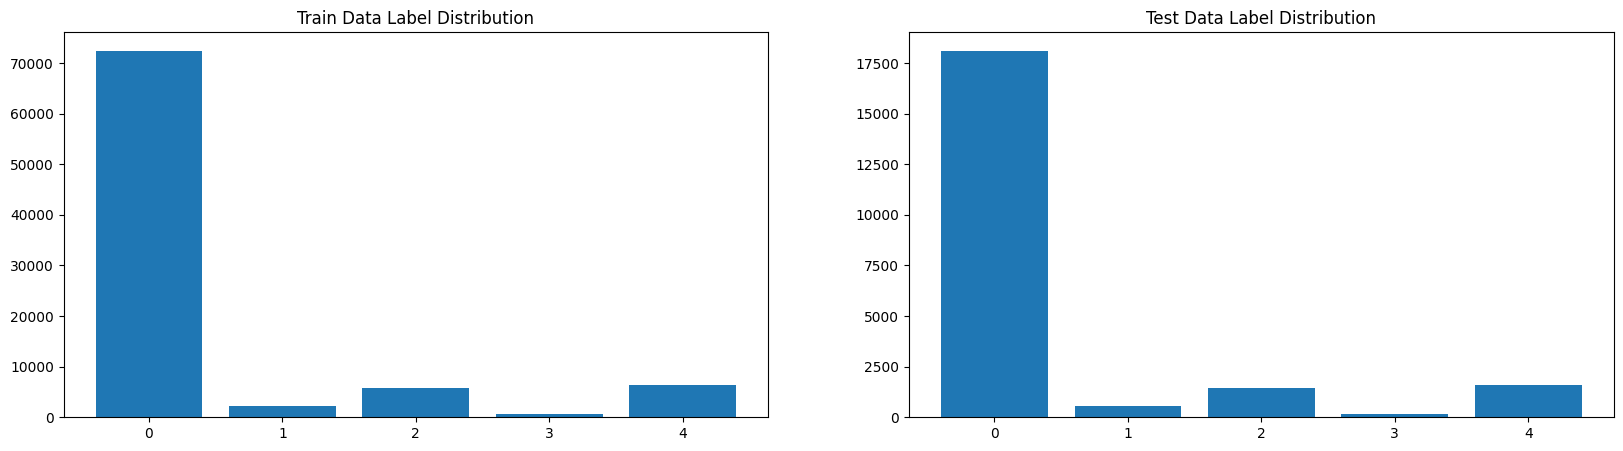

In [555]:
train_value_counts = df_train["label"].value_counts()
test_value_counts = df_test["label"].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_value_counts.index, train_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_value_counts.index, test_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

In [556]:
print("Class Proportions")
train_value_counts / np.sum(train_value_counts)

Class Proportions


0    0.827729
4    0.073452
2    0.066108
1    0.025390
3    0.007321
Name: label, dtype: float64

This is a very unbalanced dataset, with almost 83% examples being normal normal heartbeats (category 0) and the rest being various arrhythmias. Therefore it is important to used stratified sampling to down sample the data, which will preserve the distribution of data classes. This can be done using the train_test_split() method from sklearn. 

In [557]:
downsampling_factor = 0.1

_, df_train_sub = train_test_split(df_train, test_size=downsampling_factor, stratify=df_train["label"], random_state=42)
_, df_test_sub = train_test_split(df_test, test_size=downsampling_factor, stratify=df_test["label"], random_state=42)

print(f"Train Dataframe Shape = {df_train_sub.shape}")
print(f"Test Dataframe Shape = {df_test_sub.shape}")

Train Dataframe Shape = (8756, 188)
Test Dataframe Shape = (2190, 188)


Now now check the distribution of the down sampled data to make sure that it resembles the distribution of the original data.

Text(0.5, 1.0, 'Test Data Label Distribution')

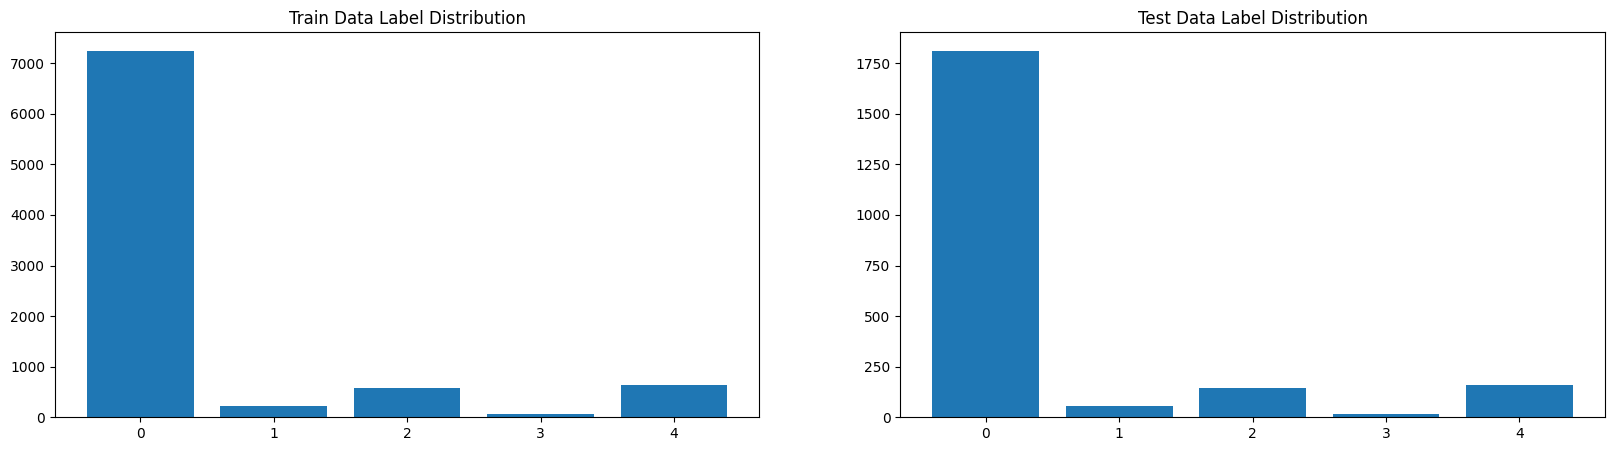

In [558]:
train_sub_value_counts = df_train_sub["label"].value_counts()
test_sub_value_counts = df_test_sub["label"].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_sub_value_counts.index, train_sub_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_sub_value_counts.index, test_sub_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

Finally, confirm that there are no missing values present in the data.

In [559]:
print(f"Missing Values in train set: {df_train_sub.isnull().values.any()}")
print(f"Missing Values in test set: {df_test_sub.isnull().values.any()}")

Missing Values in train set: False
Missing Values in test set: False


# Exploratory Data Analysis

Start by visualizing a few examples of each heart beat type. 

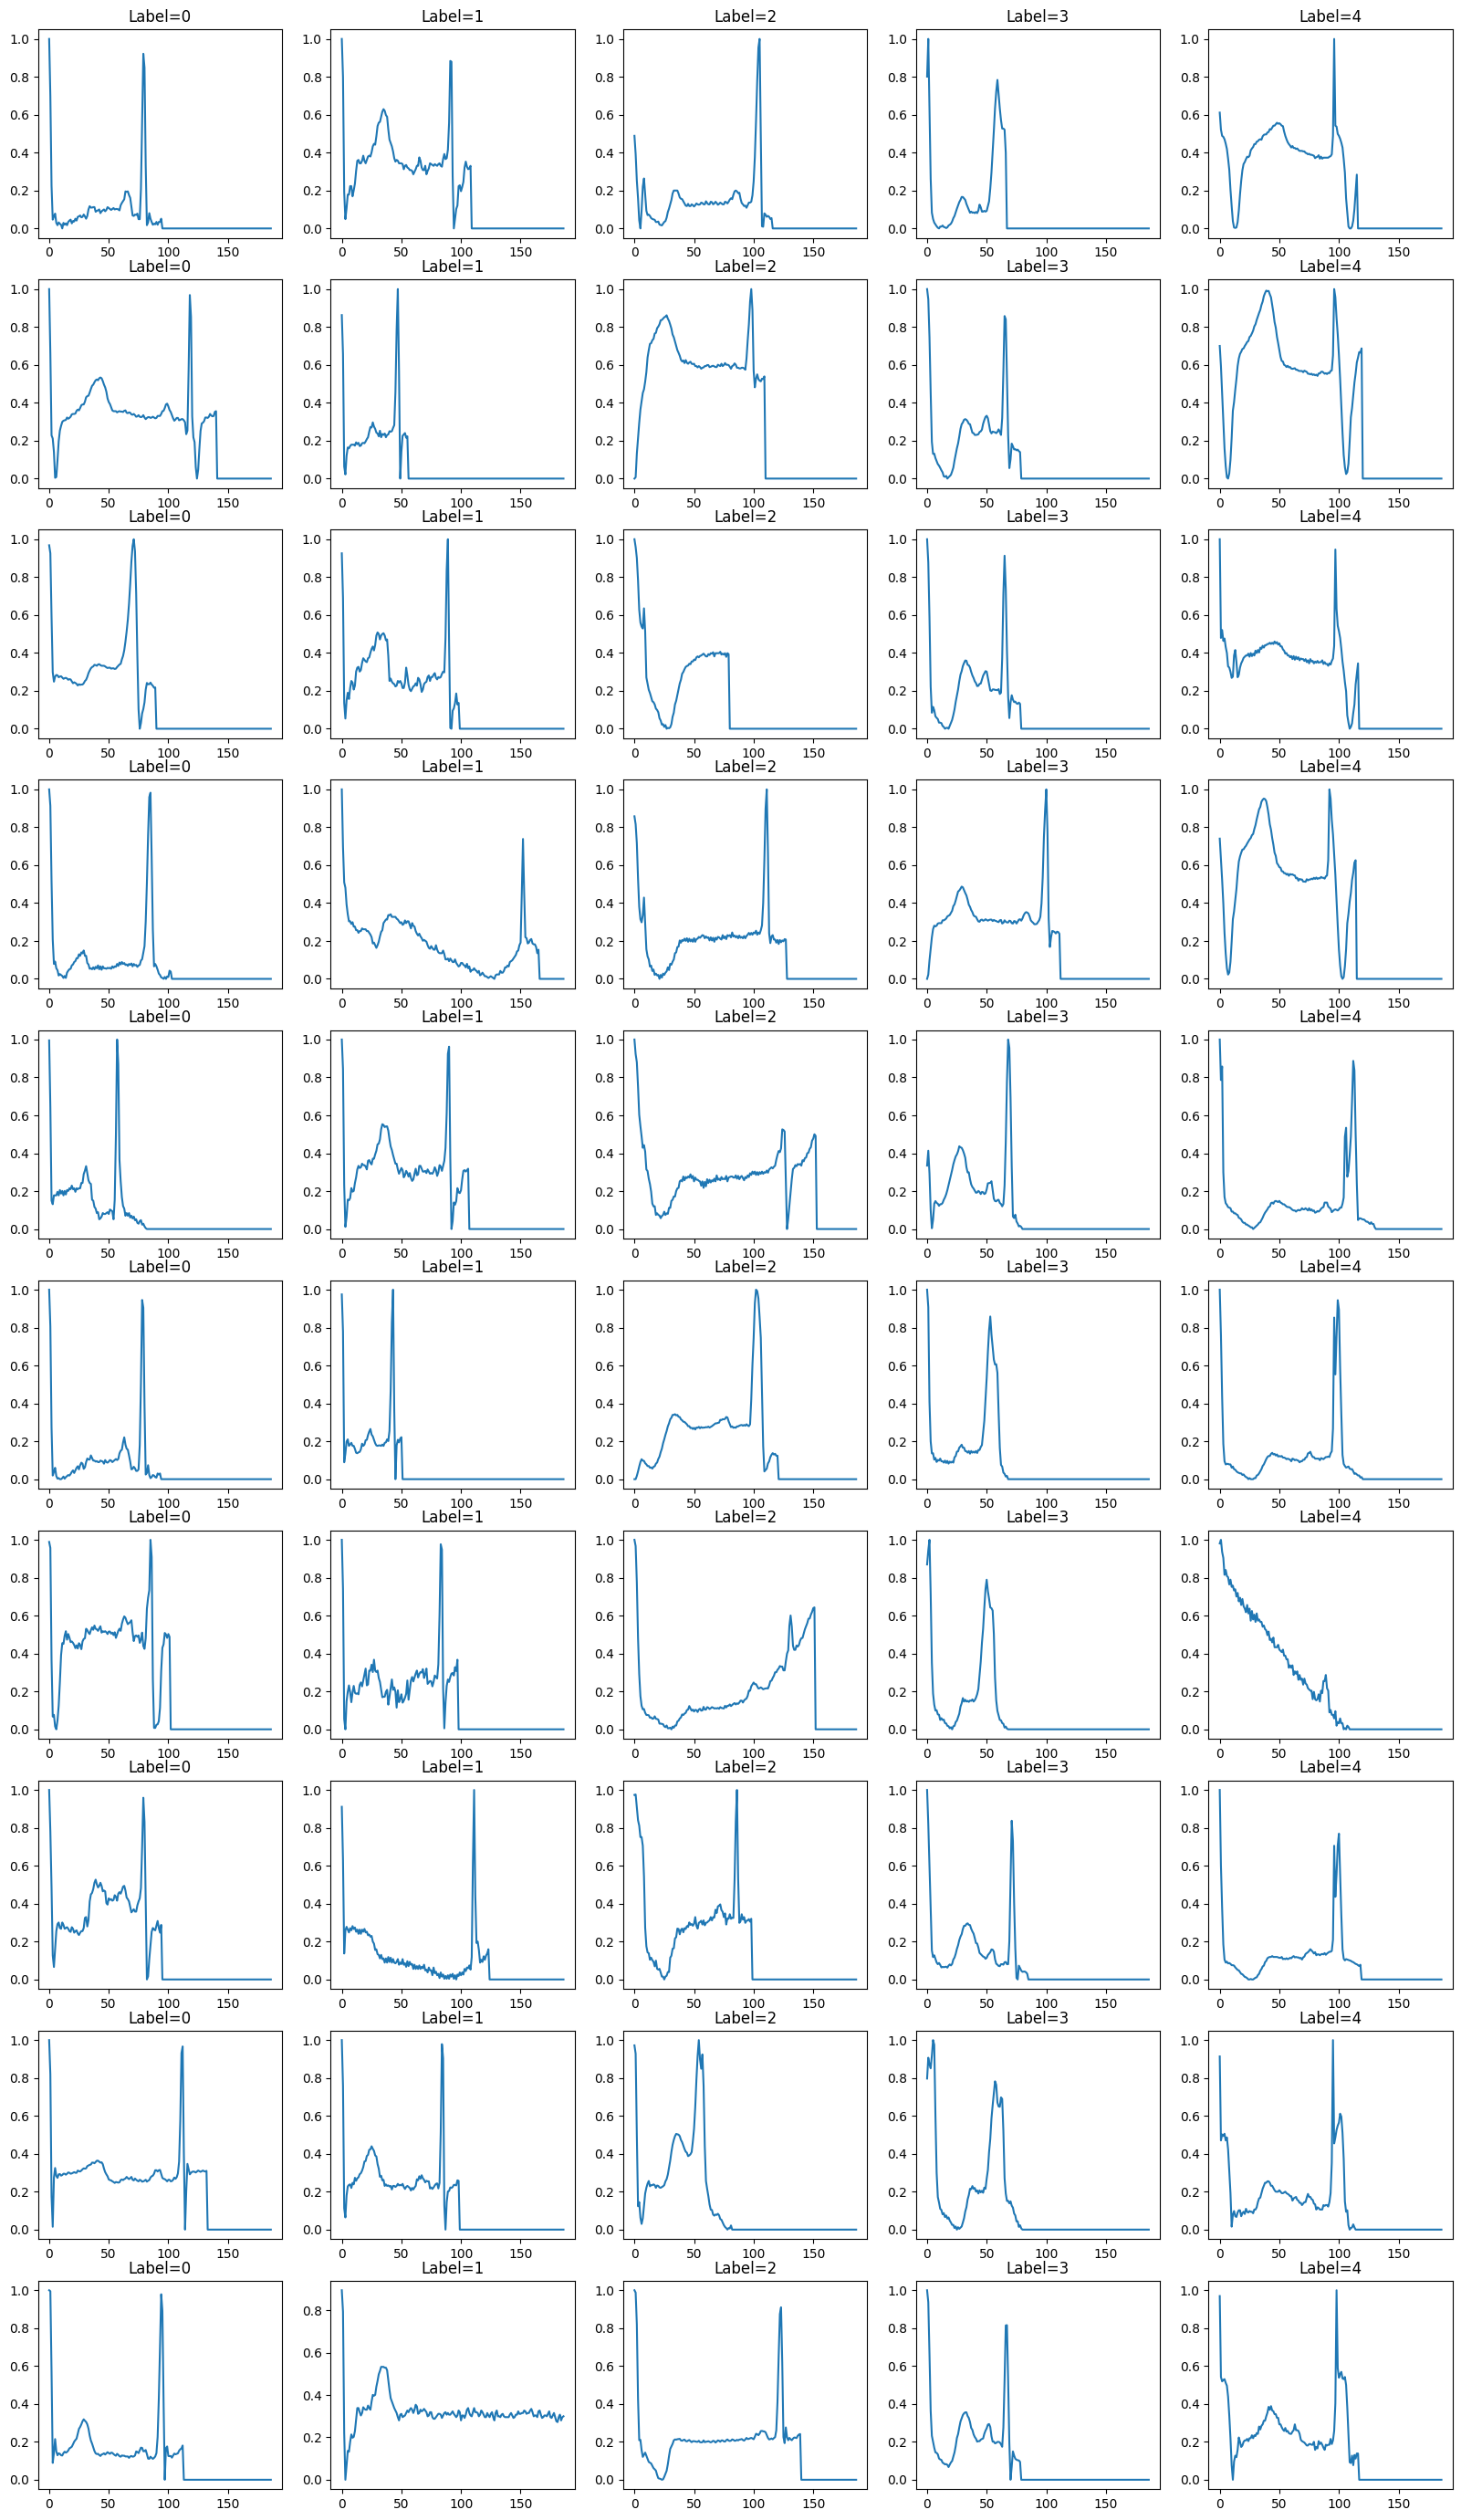

In [560]:
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_train_sub[df_train_sub["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")
        


Even in these ten examples the only class that has good consistency in visual appearance is the normal heartbeats (class 0). Within class 0 every example has the large spike in a different spot meaning that that is not a consistent feature to look for. Almost every example is also zero padded at the end, meaning that the later features in the time series are unlikely to be as relevant as the early features.

In order to introduce some summary statistics of the waveform into the datasets, the mean and standard deviation of each time series will be added as additional features. 

In [561]:
train_means = df_train_sub.drop(['label'], axis=1).mean(axis=1)
train_stds = df_train_sub.drop(['label'], axis=1).std(axis=1)
df_train_sub["mean"] = train_means
df_train_sub["std"] = train_stds

test_means = df_test_sub.drop(['label'], axis=1).mean(axis=1)
test_stds = df_test_sub.drop(['label'], axis=1).std(axis=1)
df_test_sub["mean"] = test_means
df_test_sub["std"] = test_stds

# Correlation Matrix

<Axes: >

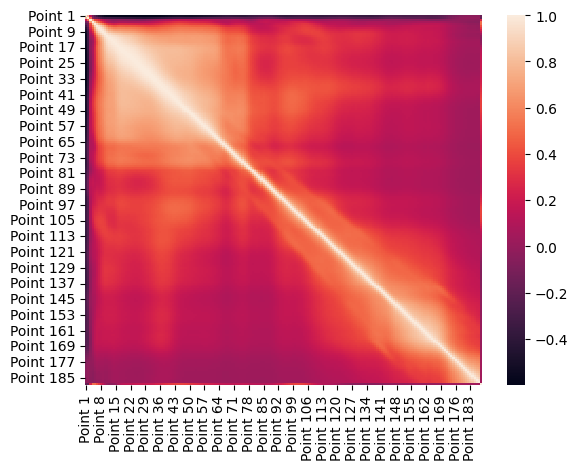

In [562]:
sns.heatmap(df_train.corr())

The large number of features in this dataset make it hard to make any feature selection decisions based on this correlation matrix. However there are still some interesting observations to be made from this correlation matrix heat map.
- The first ~30% of the dataset shows a high level of correlation between features, suggesting the presence of significant features in this segment of the ECG. This may also be due to the absence of zero-padding at this stage.
- In the later points of the dataset, where zero-padding is more prevalent, there is little to no correlation between features.
- The correlation between neighboring points is notably high, which is expected given that these points represent a discrete sampling of a continuous waveform. 


# Outlier Detection and Removal

To visualize outliers, a simple approach will be used. First generate a scatter plot to visualize the relationship between the mean and the standard deviation of all examples in the training set 

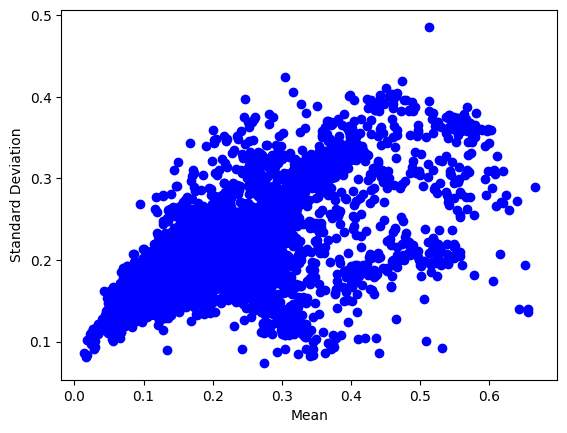

In [563]:
plt.scatter(df_train_sub["mean"], df_train_sub["std"], c="blue")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

A majority of the points in this dataset lie within one large cluster in the mean/standard deviation space but there are some outliers. In order to algorithmically find these outliers, the DBSCAN clustering algorithm is used, which is a clustering algorithm with a concept points that don't fit into any cluster. Any point that is not part of the main cluster will be considered an outlier. 

Note: The hyper-parameters of the DBSCAN algorithm eps and min_samples were chosen manually through trial and error

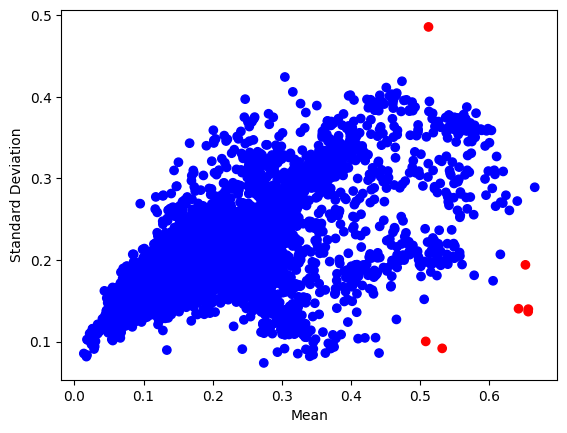

In [564]:
dbs = DBSCAN(eps=0.05, min_samples=10).fit(df_train_sub[["mean", "std"]])
dbs.labels_

colors = []
for label in dbs.labels_:
    if label == -1:
        colors.append("red")
    else:
        colors.append("blue")

plt.scatter(df_train_sub["mean"], df_train_sub["std"], c=colors)
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

Now visualize the ECG waves of these outliers:

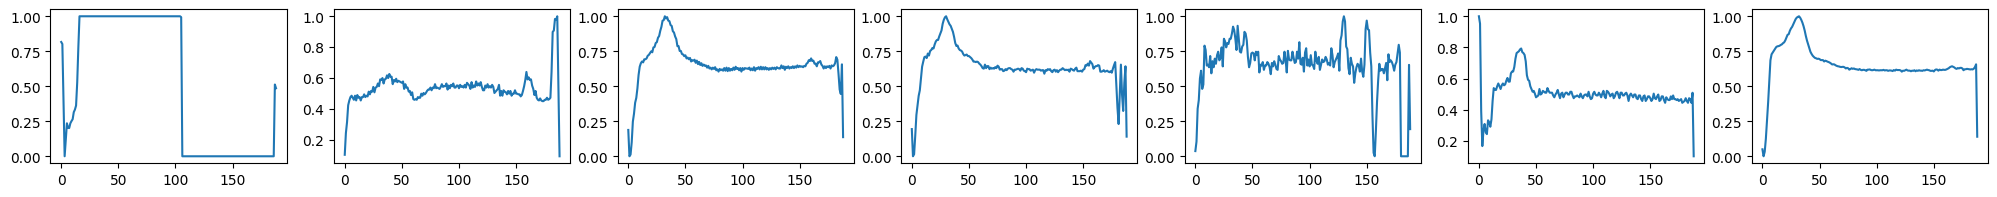

In [565]:
fig, axs = plt.subplots(nrows=1, ncols=len(outlier_df), figsize=(25, 2))
for i, data in enumerate(outlier_df.drop(["label"], axis=1).values):
    axs[i].plot(range(len(data)), data)
plt.show()

The only one of these outliers that appears to be an unreasonable ECG waveform is the first one. A possible reason to explain why the rest are outliers is that they have very little padded zeros at the end and so their means are higher while their standard deviations are lower. 

Only the first outlier above will be removed from the dataset

In [566]:
df_train_sub = df_train_sub.drop([outlier_df.iloc[0].name], axis=0)

# Feature Selection With Random Forest

First convert the train and test dataframes into numpy arrays from this point forward

In [567]:
X_train = df_train_sub.drop(['label'], axis=1).values
X_test = df_test_sub.drop(['label'], axis=1).values
y_train = df_train_sub["label"].values
y_test = df_test_sub["label"].values

One way to perform feature selection on a dataset is through the use of a Random Forest. Once a random forest is trained an estimation of the feature importances can be extracted.

First fit a random forest classifier to the training data. It is important to search over a wide range of hyper parameter choices but it is computationally intensive to do so, so a random search over the hyper parameters will be used rather than a grid search. 

In cases like this one where the dataset is highly unbalanced, classification accuracy may not be an appropriate evaluation metric for the model. Instead, the Macro F1 score is recommended, which provides the mean F1 score across all individual classes, and will be utilized for this model and all subsequent models.

In [568]:
rf_parameters = dict(n_estimators = [10*i for i in range(1, 11)],
                     max_depth = [2**i for i in range(11)]+[None],
                     min_samples_split = [i+1 for i in range(1, 10)],
                     min_samples_leaf = [i for i in range(1, 10)])
scorer = make_scorer(f1_score, average="macro")

rf_feature_select = train_model(RandomForestClassifier(random_state=42),
                                X_train, y_train, "random", "rf_feature_select", 
                                param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=100, random_state=42)                                 


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 32}


In [569]:
rf_feature_select.best_params_

{'n_estimators': 80,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 32}

Macro F1 Score = 0.819340734981622


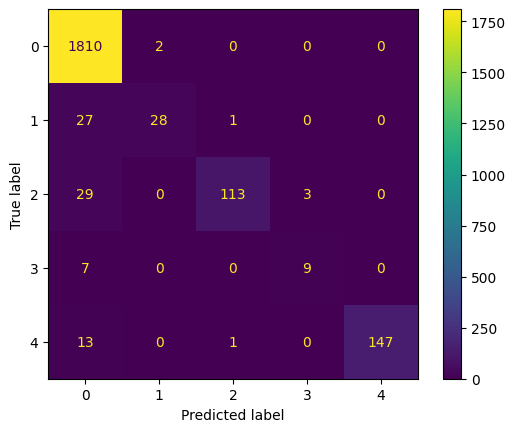

In [570]:
make_confusion_matrix(rf_feature_select, X_test, y_test)

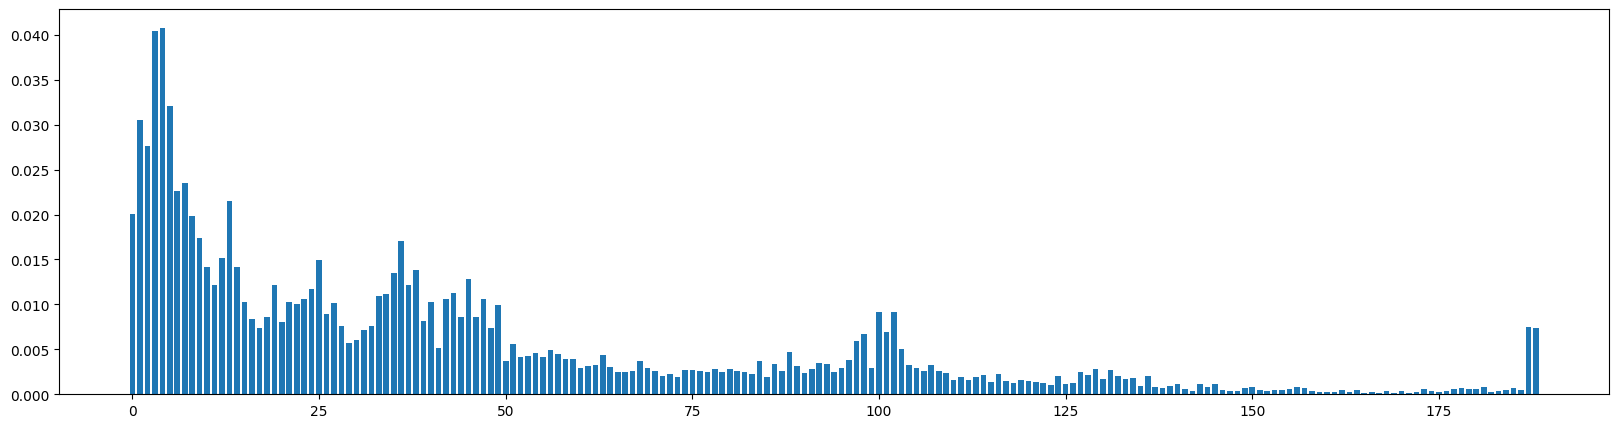

In [571]:
feature_importances = rf_feature_select.best_estimator_.feature_importances_
feature_names = np.array(column_names, dtype=object)

plt.figure(figsize=(20, 5))
plt.bar([i for i in range(len(feature_importances))], feature_importances, width=0.75)
plt.show()

The early points in this dataset are much more significant features than the later points. In general the feature importance seems to roughly decay towards 0 as you move along the ECG waveform. The later features are mostly padded zeros, which explains their low significance. The mean and standard deviation features added above (the last two points) are also moderately significant.

In order to filter out some of the less significant features, all features with a significance of > 0.005 will be considered insignificant. Later analysis will compare if this feature selection helps or hinders the model fitting. 

In [572]:
feature_mask = feature_importances > 0.005
X_train_filtered = X_train[:, feature_mask]
X_test_filtered = X_test[:, feature_mask]

print(f"Filtered Train Shape: {X_train_filtered.shape}")
print(f"Filtered Test Shape: {X_test_filtered.shape}")

Filtered Train Shape: (8755, 59)
Filtered Test Shape: (2190, 59)


# KNN

Start by fitting a K-Nearest Neighbors (KNN) model to the full unfiltered training dataset, using 5-fold cross validation to search over a range of values for K using the macro F1 score as the evaluation metric.

In [573]:
knn_parameters = dict(n_neighbors=[i for i in range(1, 10)])

knn_full = train_model(KNeighborsClassifier(),
                       X_train, y_train, "grid", "knn_full",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(None, knn_full, "knn_full", X_test, y_test)

Best Model Parameters
{'n_neighbors': 3}


Macro F1 Score = 0.7984347919904761


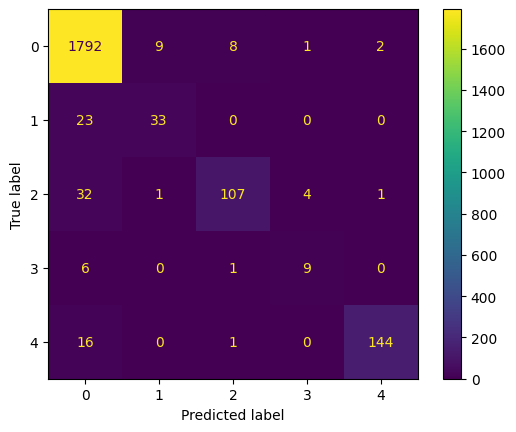

In [574]:
make_confusion_matrix(knn_full, X_test, y_test)

Now perform the same procedure to fit a KNN model to the training dataset filtered with the feature importance threshold. 

In [575]:
knn_filtered = train_model(KNeighborsClassifier(),
                           X_train_filtered, y_train, "grid", "knn_filtered",
                           param_grid=knn_parameters, scoring=scorer)
model_summary_df = add_to_model_summary_df(model_summary_df, knn_filtered, "knn_filtered", X_test_filtered, y_test)

Best Model Parameters
{'n_neighbors': 1}


Macro F1 Score = 0.8412712529800273


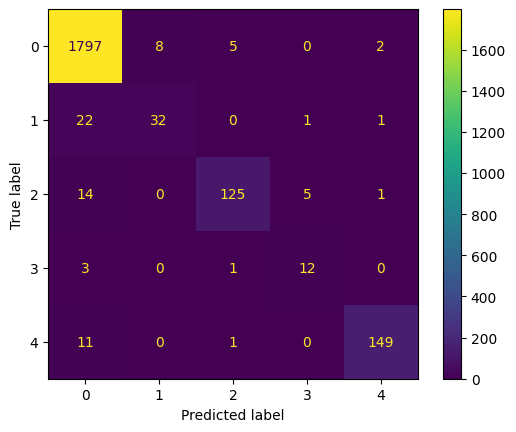

In [576]:
make_confusion_matrix(knn_filtered, X_test_filtered, y_test)

# Random Forest

Fit a random forest model to the full dataset, doing the same random search with 5-fold cross validation over the parameters that was used when fitting the random forest used for feature importance above.

In [577]:
rf_full = train_model(RandomForestClassifier(random_state=42),
                      X_train, y_train, "random", "rf_full",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_full, "rf_full", X_test, y_test)

Best Model Parameters
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 1024}


Macro F1 Score = 0.8028023996272614


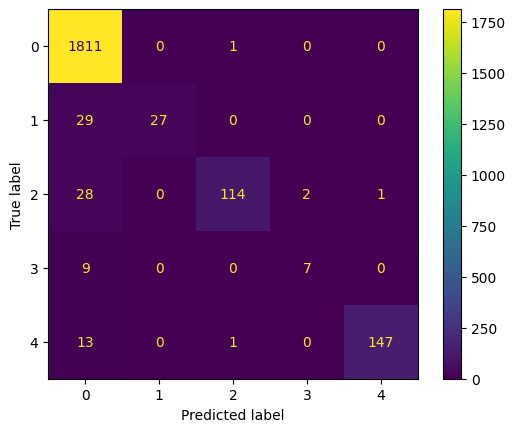

In [578]:
make_confusion_matrix(rf_full, X_test, y_test)

Now perform the same procedure to fit a random forest model to the filtered training dataset. 

In [579]:
rf_filtered = train_model(RandomForestClassifier(random_state=42),
                          X_train_filtered, y_train, "random", "rf_filtered",
                          param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_filtered, "rf_filtered", X_test_filtered, y_test)

Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 128}


Macro F1 Score = 0.8138957027712237


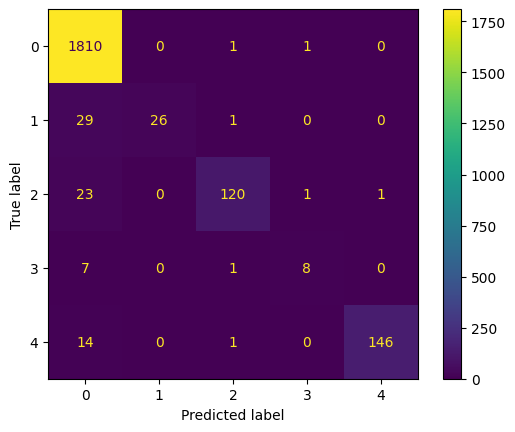

In [580]:
make_confusion_matrix(rf_filtered, X_test_filtered, y_test)

# Gradient Boosting

Fit a gradient boosting model to the full dataset, doing a random search with 5-fold cross validation over several hyper parameters. 

In [581]:
gb_params = dict(n_estimators = [10*i for i in range(1, 11)],
                 max_depth = [1, 2, 3, 4, 5]+[None],
                 min_samples_split = [i+1 for i in range(1, 10)],
                 min_samples_leaf = [i for i in range(1, 10)],
                 learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5])

gb_full = train_model(GradientBoostingClassifier(),
                      X_train, y_train, "random", "gb_full",
                      param_distributions=gb_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=100)

model_summary_df = add_to_model_summary_df(model_summary_df, gb_full, "gb_full", X_test, y_test)

Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_depth': None, 'learning_rate': 0.1}


Macro F1 Score = 0.803499181109409


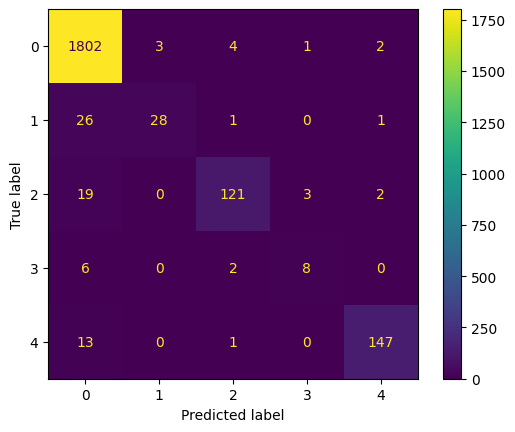

In [582]:
make_confusion_matrix(gb_full, X_test, y_test)

Now perform the same procedure to fit a gradient boosting model to the filtered training dataset. 

In [583]:
gb_filtered = train_model(GradientBoostingClassifier(),
                      X_train_filtered, y_train, "random", "gb_filtered",
                      param_distributions=gb_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=100)

model_summary_df = add_to_model_summary_df(model_summary_df, gb_filtered, "gb_filtered", X_test_filtered, y_test)

Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': None, 'learning_rate': 0.1}


Macro F1 Score = 0.8344991787537571


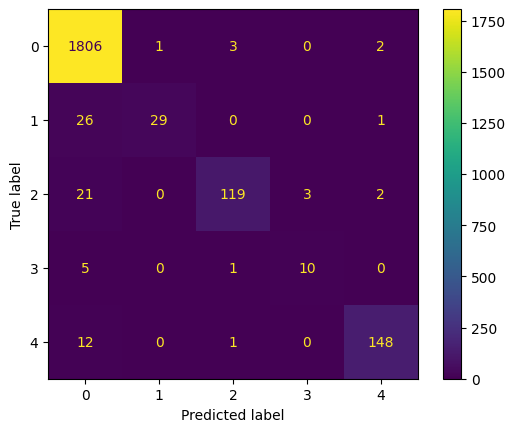

In [584]:
make_confusion_matrix(gb_filtered, X_test_filtered, y_test)

# SVM

Finally, fit a support vector machine model to the full dataset, doing a random search with 5-fold cross validation over several hyper parameters. Several different kernels are tested out. Additionally the `class_weight` parameter is meant to account for imbalanced datasets, which this ECG dataset is, is also included in the grid search. 

In [585]:
svc_params = dict(C=np.logspace(-7, 7, 15, base=2),
                  gamma=np.logspace(-7, 7, 15, base=2),
                  kernel=["linear", "poly", "rbf", "sigmoid"],
                  class_weight=["balanced", None])

svc_full = train_model(SVC(), X_train, y_train, "random", "svc_full",
                       param_distributions=svc_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=200)

model_summary_df = add_to_model_summary_df(model_summary_df, svc_full, "svc_full", X_test, y_test)

Best Model Parameters
{'kernel': 'rbf', 'gamma': 0.25, 'class_weight': 'balanced', 'C': 16.0}


Macro F1 Score = 0.8161150080291348


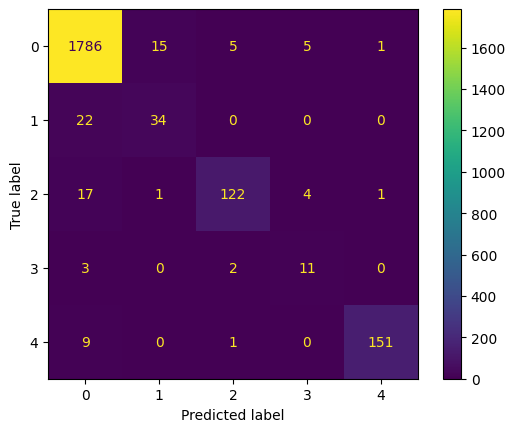

In [586]:
make_confusion_matrix(svc_full, X_test, y_test)

Now perform the same procedure to fit a support vector machine model to the filtered training dataset.

In [587]:
svc_filtered = train_model(SVC(), X_train_filtered, y_train, "random", "svc_filtered",
                           param_distributions=svc_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=200)

model_summary_df = add_to_model_summary_df(model_summary_df, svc_filtered, "svc_filtered", X_test_filtered, y_test)

Best Model Parameters
{'kernel': 'rbf', 'gamma': 2.0, 'class_weight': None, 'C': 8.0}


Macro F1 Score = 0.8662395988791592


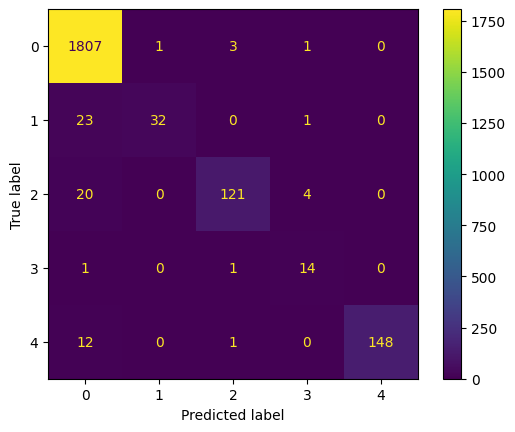

In [588]:
make_confusion_matrix(svc_filtered, X_test_filtered, y_test)

# Results

Throughout all of the above model trainings, a model summary data frame has been built up with how each model performs according to various metrics on the test dataset. The metrics used are:
- Accuracy: The proportion of cases that were classified correctly. 
- Precision: The proportion of instances correctly classified as a specific class out of all instances classified as that class. Averaged over all classes
- Recall: The proportion of instances that were correctly classified as a specific class, out of all the instances that actually belong to that class. Averaged over all the classes
- Macro F1: The harmonic mean of precision and recall, a way of combining them both into a single metric.
- Train Time: The amount of time it took the model to train 

In [589]:
model_summary_df

,Name,Accuracy,Precision,Recall,Macro F1,Train Time
0,knn_full,0.952055,0.852644,0.754618,0.798435,0.056851
1,knn_filtered,0.965753,0.872084,0.820137,0.841271,0.036233
2,rf_full,0.961644,0.942396,0.723668,0.802802,772.897667
3,rf_filtered,0.963470,0.944434,0.739520,0.813896,665.568269
4,gb_full,0.961644,0.888137,0.748401,0.803499,28141.781489
5,gb_filtered,0.964384,0.925734,0.775898,0.834499,11974.935475
6,svc_full,0.960731,0.825525,0.811912,0.816115,5441.559207
7,svc_filtered,0.968950,0.919991,0.839481,0.866240,1054.380325


Use bar charts to visualize how the different models perform according to the different metrics

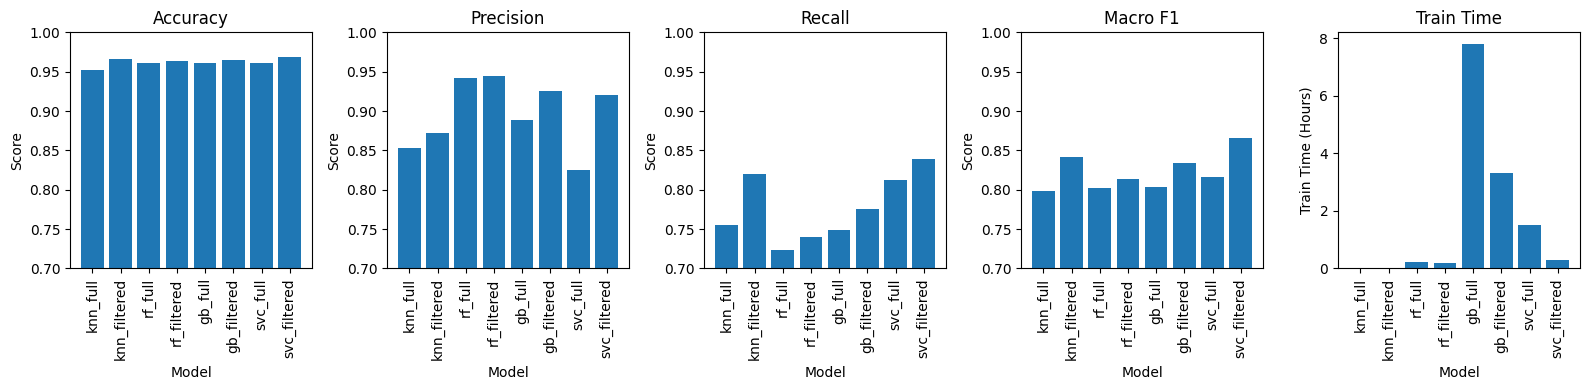

In [590]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
metrics = ["Accuracy", "Precision", "Recall", "Macro F1"]

for i, metric in enumerate(metrics):
    axs[i].bar(model_summary_df["Name"], model_summary_df[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Model")
    axs[i].set_ylabel("Score")
    axs[i].set_ylim(0.7, 1.0)
    axs[i].tick_params(axis='x', rotation=90)
    
axs[4].bar(model_summary_df["Name"], model_summary_df["Train Time"]/3600)
axs[4].set_title("Train Time")
axs[4].set_xlabel("Model")
axs[4].set_ylabel("Train Time (Hours)")
axs[4].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()

Interesting notes about each metric:

- Accuracy: Due to the imbalanced nature of the dataset the accuracy score is very high for every model. A completely naive model that assumes that all heart beats are healthy (the majority class) would only have ~83% accuracy so all of these models represent a significant improvement over that naive model. All models perform similarly according to accuracy with the SVC trained on the filtered data having a slight edge.
</br>

- Precision and Recall: The Random Forest Models performed best in precision but worst in recall. This means that they led to a low amount of false positives but a large amount of false negatives.
</br>

- Macro F1: Combining precision and recall together into the Macro F1 score shows that on average, most of the models are preforming very similarly. The full dataset KNN performs the worst, which makes sense as it is the most simple model with no feature selection. The KNN trained on the  The SVC trained on the filtered data performs the best, but only slightly.
</br>

- Train Times: The KNN models trained almost instantly as there is no processing when they are trained, only the storing of the training data. The Random Forest Models both trained in under 15 minutes meaning those models train relatively fast. The Gradient Boosting model on the full dataset took the longest to train at almost eight hours, with the gradient boosting model on the filtered dataset taking under half that time. This illustrates that gradient boosting models train very slowly compared to other models. Finally the SVC model trained on the full dataset trained in about 1.5 hr while the SVC model trained on filtered data trained in ~17 min, meaning that decreasing the number of features sped up the SVC model significantly.

Additionally, for all model types across all metrics except for train time, the filtered version of the model performed better, meaning that the random forest based feature selection was a valid way to improve the models.

I would appear based on all of these metrics the the Support Vector Classifier trained on the filtered dataset is the clear winner as it has the best performance according to 3 out of the 4 performance metrics as well as a reasonable train time. The only metric where this model is not the best performer is precision. For classifying heartbeats it makes sense to prioritize avoiding false negatives rather than false positives, although ideally both should be avoided. A false negative potentially means that the algorithm missed identifying a dangerous arrhythmia which could be life threatening while a false positive means the algorithm mislabeled a heartbeat as arrhythmia which, especially if looked at by a medical professional, would likely be caught quickly. Therefore recall should be prioritized over precision as a high recall minimizes false negatives. 

# Discussion and Conclusion

The end goal of this project was to be able to build a machine learning model that is able to classify heartbeats represented by ECG time series data as either normal or as one of four different type of arrhythmia. A naive classifier that labels every heartbeat as the majority class would have had ~83% accuracy, this provides a good benchmark to compare other models with to show that the algorithms used are actually learning. The procedure followed was:
1. Explore and understand the data with exploratory data analysis
2. Use a clustering algorithm on summary statistics of the time series to perform outlier detection and removal
3. Train a random forest on the data and use it to extract feature importance to be used for feature selection
4. Train four different types of machine learning algorithm on the training data: K Nearest Neighbors, Random Forest, Gradient Boosted Classifier, and a Support Vector Classifier.
    * For each classifier type two models were trained, one on the training data with all features and one on the training data with only those features with a feature importance of greater than 0.005.
    * For models with a low numbers of hyperparameters (K Nearest Neighbors), a grid search was done to find the hyperparameters that perform best
    * For models with a high number of hyperparameters (The rest of them), a grid search would have been very computationally expensive, so a random search over the hyperparameter space was done instead.
    * For both grid search and random search, the models were evaluated using five fold cross validation to help ensure generalizability
    * The Macro F1 score was used as a scoring metric in the hyperparameter searches, as it provides a good evaluation of the performance of unbalanced datasets
5. After training all models, the model that performed the best was the Support Vector Classifier trained using feature selection. The final accuracy of this classifier on the test data was 96.9% representing a 13.9% improvement over the naive model. 


Although this improvement if 13.9% is significant, a classification accuracy of 96.9% is not good enough to be used in practice, at that would mean around 3 out of every 100 heartbeats would be misclassified on average. The translates to several misclassifications per minute at normal heart rates. In order to be practical to use, the model would need to achieve even higher accuracy. Below are some ideas for potential ways to improve the model if it were to be iterated on:
* Train on the entire available dataset: For computation reasons, the train and test datasets were decreased in size by 10x however using all of that data would likely lead to a better model. 
* Do more through hyper parameter searches:  Again for computational reasons, only a random search was done for three of the model types, meaning only a small subset of the possible hyper parameter were checked. Given more time or a faster computer a larger random search or even a full grid search could have been done to find better hyper parameters
* Better feature importance cutoff: The analysis showed that all models where feature selection was done performed better across all metrics that models where it wasn't. The feature importance cutoff of 0.005 was chosen somewhat arbitrarily based on visual inspection of a plot. If this number was tuned along with other hyper parameters when training models, perhaps a better value could have been found.
* Calculate new features: Only the raw time series points along with their mean and standard deviation were used as features for this classification. Additional features could have been calculated and added to the datasets that could have lead to better models. Some ideas for new features:
    * Frequency domain coefficients calculated with Fourier or wavelet analysis of the time series data.
    * Medically informed statistics like the intervals of the various parts of the ECG wave such as the PR Interval or the QRS Complex